# HW1 
For Homework 1, I will opt to do part II of the homework. Firstly, I will be importing several libraries for my analysis and cleaning the data. The data will be pulled from the yfinance API for 5-years of historical trading data ranging from 2019-08-01 to 2024-08-01. The two commodities for these will be the Crude Oil Oct 2024 futures market and the Natural Gas Oct 2024 futures market.

In [14]:
# Financial libraries
import yfinance as yf
import gs_quant.timeseries.econometrics as gs
from gs_quant.timeseries.econometrics import Returns

# Numerical Libraries
import pandas as pd
from scipy.stats import jarque_bera, skew, kurtosis, norm, ttest_1samp
import numpy as np
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS, OLSResults
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plotting Libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
from matplotlib import pyplot as plt

# To ignore warnings
import warnings

In [15]:
warnings.filterwarnings('ignore')

In [16]:
# Dowloading data using yfinance API
crude = yf.download('CL=F', start='2019-01-01', end='2024-08-01')
ng = yf.download('NG=F', start='2019-01-01', end='2024-08-01')

# Cleaning data for analysis
crude.reset_index(inplace=True)
ng.reset_index(inplace=True)

crude.rename(columns={'Adj Close' : 'crude_price'},inplace=True)
ng.rename(columns={'Adj Close' : 'ng_price'}, inplace=True)

prices=crude[['Date','crude_price']]
prices['ng_price']=ng['ng_price']

prices.drop(prices['crude_price'].idxmin(),inplace=True)

# Calculating log returns via gsquant
prices['crude_log_returns']=gs.returns(prices['crude_price'],type=Returns.LOGARITHMIC)
prices['ng_log_returns']=gs.returns(prices['ng_price'],type=Returns.LOGARITHMIC)

prices.fillna(0,inplace=True)

# Mean and Std for each of the log returns
crude_mean, crude_std = np.mean(prices['crude_log_returns']), np.std(prices['crude_log_returns'])
ng_mean, ng_std = np.mean(prices['ng_log_returns']), np.std(prices['ng_log_returns'])

# Filtering out extreme outliers
top_crude = crude_mean + 3 * crude_std
bottom_crude = crude_mean - 3 * crude_std
top_ng = ng_mean + 3 * ng_std
bottom_ng = ng_mean - 3 * ng_std

# Filter df to only include 99.7% of the data
prices = prices[(prices['crude_log_returns'] >= bottom_crude) & 
                    (prices['crude_log_returns'] <= top_crude) &
                    (prices['ng_log_returns'] >= bottom_ng) & 
                    (prices['ng_log_returns'] <= top_ng)]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Visualization

Below is an interactive chart using the Plotly API.

In [17]:
# Create a 4x1 subplot for crude price, ng price, crude log returns, and ng log returns
fig = make_subplots(rows=4, cols=1, subplot_titles=("Crude Oil Prices", "Natural Gas Prices", 
                                                    "Crude Oil Log Returns", "Natural Gas Log Returns"))

# Crude price
fig.add_trace(go.Scatter(x=prices['Date'], y=prices['crude_price'], mode='lines', name='Crude Oil Prices'), row=1, col=1)

# NG price
fig.add_trace(go.Scatter(x=prices['Date'], y=prices['ng_price'], mode='lines', name='Natural Gas Prices'), row=2, col=1)

# Crude log returns
fig.add_trace(go.Scatter(x=prices['Date'], y=prices['crude_log_returns'], mode='lines', name='Crude Oil Log Returns'), row=3, col=1)

# NG log returns
fig.add_trace(go.Scatter(x=prices['Date'], y=prices['ng_log_returns'], mode='lines', name='Natural Gas Log Returns'), row=4, col=1)

# Update layout to set the title and axis labels
fig.update_layout(height=900, title_text="Crude Oil and Natural Gas Prices and Log Returns", showlegend=False)

# Show the plot
fig.show()


Text(0, 0.5, 'NG Log Returns')

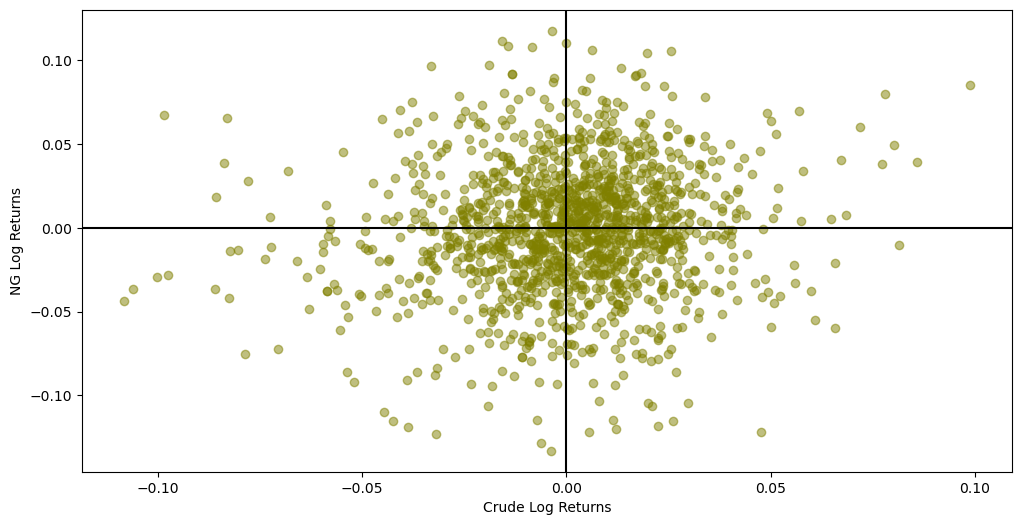

In [18]:
# Quick scatterplot of the returns series
plt.figure(figsize=(12,6))
plt.scatter(prices['crude_log_returns'], prices['ng_log_returns'],alpha=.5,color='olive')
plt.axhline(y=0,color='black')
plt.axvline(x=0,color='black')
plt.xlabel('Crude Log Returns')
plt.ylabel('NG Log Returns')


## Summary Stats

Next are summary statistics for the data.

In [19]:
# Summary Statistics
summary=prices[['crude_price','ng_price','crude_log_returns','ng_log_returns']].describe()

# Skewness
skewness = [skew(prices[column]) for column in prices.columns[1:]]

# Kurtosis
kurt= [kurtosis(prices[column]) for column in prices.columns[1:]]

# Adding to dataframe
summary.loc[len(summary.index)] = skewness 
summary.rename(index={len(summary.index) - 1: 'skew'}, inplace=True)

summary.loc[len(summary.index)] = kurt
summary.rename(index={len(summary.index) - 1: 'kurt'}, inplace=True)


display(summary)

,crude_price,ng_price,crude_log_returns,ng_log_returns
count,1369.000000,1369.000000,1369.000000,1369.000000
mean,68.872250,3.387272,0.000479,-0.000895
std,19.102542,1.784915,0.024287,0.038724
min,12.340000,1.482000,-0.108290,-0.133143
25%,56.070000,2.305000,-0.012006,-0.024400
50%,71.290001,2.680000,0.002175,-0.000369
75%,80.830002,3.834000,0.014689,0.022759
max,123.699997,9.680000,0.098721,0.117783
skew,-0.012112,1.638703,-0.491795,-0.161050
kurt,0.041275,1.886923,2.078200,0.526538


## Normality Testing

### Jarque-Bera Test

Now we will test for the normality of the data by using the Jarque-Bera (JB) test. We recall that 

\begin{align*}
    JB=\frac{\hat{S}^2(r)}{6/T} + \frac{(\hat{K}(r)-3)^2}{24/T}
\end{align*}

and we compute the p-value by subtracting the PDF of the 2-DoF $\Chi^2$ distribution evaluated at the statistic from 1.

\begin{align*}
    p = 1-F(JB,2)
\end{align*}

We consider the hypotheses:

\begin{align*}
    H_0: \text{The data is normally distributed} \\
    H_a: \text{The data is not normally distributed}
\end{align*}

 By computing the JB Statistic and p-values, we have (301.5432,0.000) for the crude log returns series, and (21.7324,0.000) for the NG log returns. Both of these series have quite high statistics and trivial p-values. This means we can reject the null-hypothesis with near certainty, which means the data is most likely not normally distributed.

In [20]:
crude_jb=jarque_bera(prices['crude_log_returns'])
ng_jb=jarque_bera(prices['ng_log_returns'])

print(f'Crude Log Returns JB Test - Statistic={crude_jb.statistic: .4f}, p-val={crude_jb.pvalue: .4f}')
print(f'NG Log Returns JB Test - Statistic={ng_jb.statistic: .4f}, p-val={ng_jb.pvalue: .4f}')

Crude Log Returns JB Test - Statistic= 301.5432, p-val= 0.0000
NG Log Returns JB Test - Statistic= 21.7324, p-val= 0.0000


### t-tests

We will also compute the skewness and excess-kurtosis t-tests for each of the series using the following formulas:

\begin{align*}
t_S=\frac{\hat{S}(r)}{\sqrt{6/T}} \quad t_K=\frac{(\hat{K}(r)-3)}{\sqrt{24/T}}
\end{align*}

For crude, the t-tests indicate that there is a large degree of negative skewness and platykurtic geometry. This indicates that the returns are far to the left of the mean (which is most likely negative in this case) and is with very thin "tails", indicating that extreme returns values are very unlikely, which can partly be attributed to the fact that we filtered out extreme outliers. For natural gas, we have another t-stat for skewness of -2.43, suggesting that the distribution of returns is more symmetric than that of oil returns, but still with a high degree of negative skewness. On the other hand, the NG log returns series has a kurtosis t-statistic of -18.68, indicating that the distribution is extremely platykurtic and perhaps that natural gas markets are very unlikely to experience extreme returns. Based off of simple observation, it is easy to reject the null hypothesis on the 95% confidence interval for all t-statistics, implying that the data is not normally distributed.

In [21]:
ts_crude = (skew(prices['crude_log_returns']))/(np.sqrt(6/len(prices['crude_log_returns'])))
tk_crude = ((kurtosis(prices['crude_log_returns'])-3))/(np.sqrt(24/len(prices['crude_log_returns'])))

ts_ng = (skew(prices['ng_log_returns']))/(np.sqrt(6/len(prices['ng_log_returns'])))
tk_ng = (kurtosis(prices['ng_log_returns'])-3)/(np.sqrt(24/len(prices['ng_log_returns'])))


print(f'Crude Log Returns skewness t={ts_crude}, kurtosis t={tk_crude}')
print(f'NG Log Returns skewness t={ts_ng}, kurtosis t={tk_ng}')

Crude Log Returns skewness t=-7.428662594935456, kurtosis t=-6.96197816727204
NG Log Returns skewness t=-2.4326971021106094, kurtosis t=-18.68104904654169


## Autocorrelation Testing

### ACF and PACF
The next cell will plot and examine the ACF and PACF of the NG log returns, the dependent variable in the regression. There seems to be no significant spikes in either plot for the data, suggesting that the NG log returns data likely does not follow a simple AR process and may be independent over time.

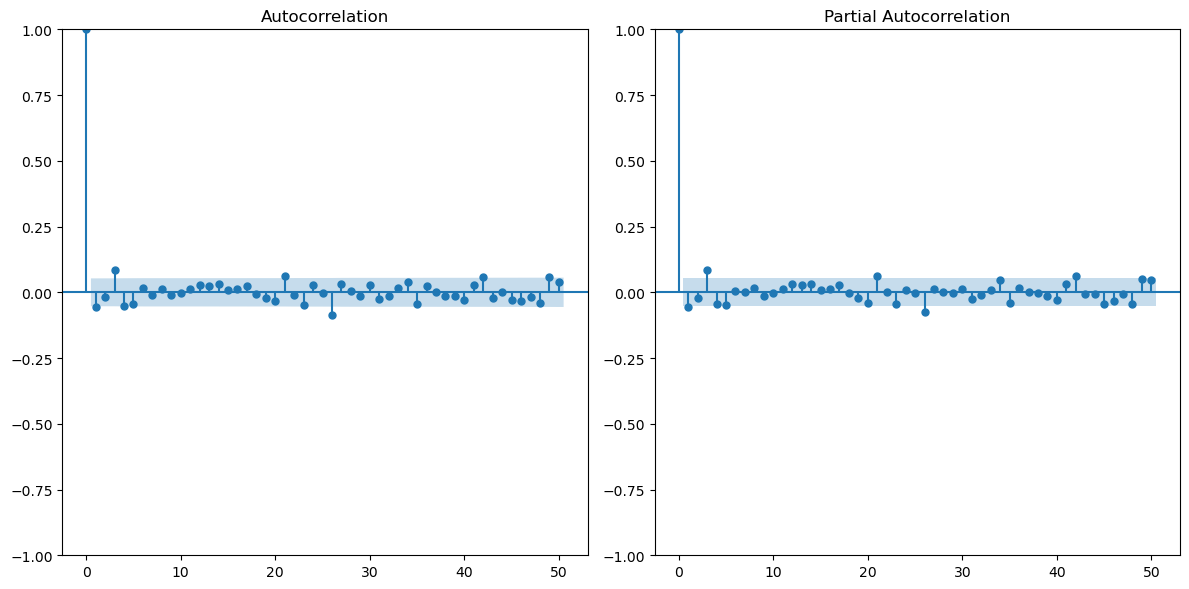

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sm.graphics.tsa.plot_acf(prices['ng_log_returns'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(prices['ng_log_returns'], lags=50, ax=ax[1])

plt.tight_layout()
plt.show()

### Ljung-Box Testing
Next, we perform a Ljung-Box test to autocorrelation of multiple lags at a time. We use the statsmodel API built-in function the LB test, which returns a dataframe of the LB stats/p-values for the first 10 lags. We consider the following hypotheses:

\begin{align*}
H_0: & \ \text{The lags up to lag } m \text{ are all zero.} \\
H_1: & \ \text{The lags up to lag } m \text{ are not all zero and there is at least one significant autocorrelation.}
\end{align*}

In computing this, we are able to observe a more significant p-value at m=2 with a value of .102254, so we fail reject the null hypothesis on the 95% confidence interval, indicating that for m=2, the data is more likely to be independent. For the other p-values, the null hypothesis is not confirmed on the 95% CI, indicating that there is serial autocrrelation in this data for these lags.

In [23]:
ljb=acorr_ljungbox(prices['ng_log_returns'])
ljb

,lb_stat,lb_pvalue
1,4.133267,0.042048
2,4.560600,0.102254
3,14.438653,0.002365
4,18.138823,0.001159
5,20.933360,0.000834
6,21.336352,0.001596
7,21.433763,0.003178
8,21.622635,0.005665
9,21.719480,0.009812
10,21.720352,0.016594


## Regression and Residuals Analysis

Finally, we will use an OLS model to estimate the affect of the Crude Log Returns on the NG Log Returns. For the constant, we have a coefficient of -.001, std error of .001, t=-.929, p=.353. The p-value suggests that it has a weak statistical significance to the model. For the independent variable, crude_log_returns, we have a coefficient of .1545, a std error of .043, t=3.600, and p=0.000, which indicates that it has a stronger statistical significance on ng_log_returns. In addition, we have an R^2 value of .009, indicating that there is little correlation and explanatory power between the variables.

In [24]:
X=prices['crude_log_returns']
X=sm.add_constant(X)
y=prices['ng_log_returns']

model=OLS(y,X)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         ng_log_returns   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     12.96
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           0.000330
Time:                        21:21:02   Log-Likelihood:                 2515.5
No. Observations:                1369   AIC:                            -5027.
Df Residuals:                    1367   BIC:                            -5016.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0010      0.00

We will use the residuals of the results to test for autocorrelated residuals. The ACF and PACF of the residuals follows a very similar pattern to that of the original data. Similarly, at m=2, the LB test p-value is .07198, meaning we again fail to reject the null hypothesis on the 95% confidence interval. The rest of the p-values indicate serial autocorrelation in the residuals.

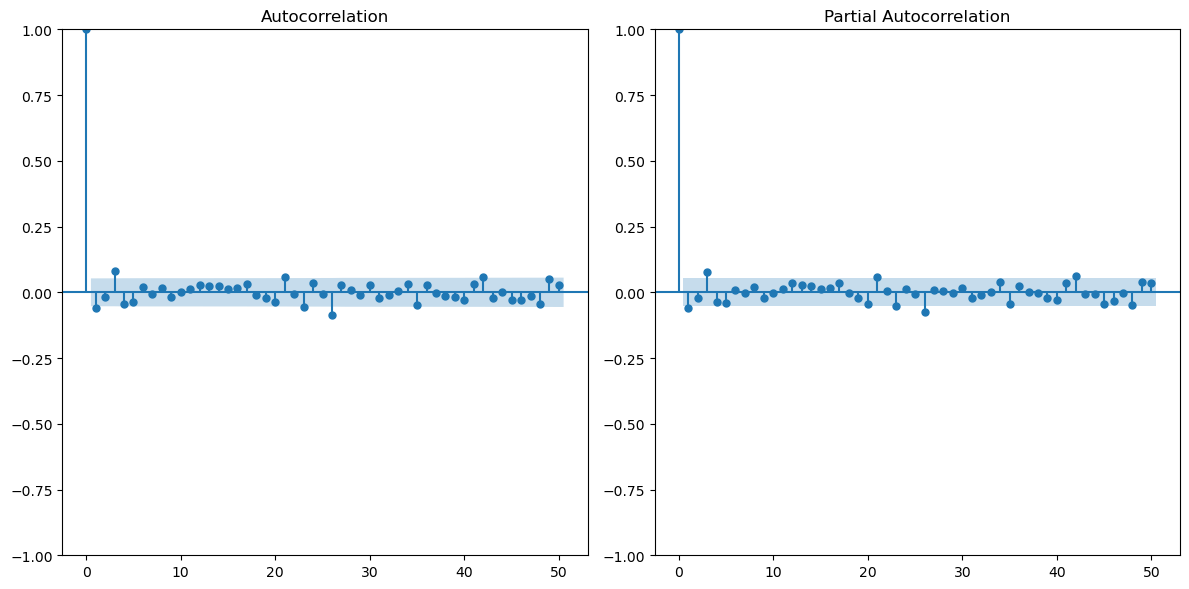

,lb_stat,lb_pvalue
1,4.854212,0.027579
2,5.262730,0.071980
3,14.290843,0.002535
4,17.047168,0.001893
5,18.930132,0.001981
6,19.461308,0.003452
7,19.543477,0.006645
8,19.896971,0.010733
9,20.341860,0.015916
10,20.341913,0.026180


In [25]:
residuals = results.resid 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])

plt.tight_layout()
plt.show()

ljb_resid=acorr_ljungbox(residuals)
ljb_resid